# Lab10 : In Lab Exercise

## st121411

Image dimensions: (300, 451, 3)


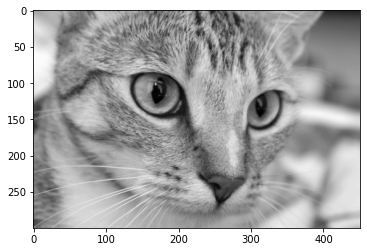

In [1]:
import skimage.data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Read image

img = skimage.data.chelsea()
print('Image dimensions:', img.shape)

# Convert to grayscale

img = skimage.color.rgb2gray(img)
plt.imshow(img, cmap='gray')
plt.show()

### Create some filters for the conv layer

Recall that a conv layer uses some number of convolution (actually cross correlation) filters, usually matching the number
of channels in the input (1 in our case since the image is grayscale). Each kernel gives us one feature map (channel) in the
result.

Let's make two 3$\times$3 filters, using the horizontal and vertical Sobel edge filters:

In [2]:
l1_filters = np.zeros((2,3,3))
l1_filters[0, :, :] = np.array([[[-1, 0, 1], 
                                 [-2, 0, 2], 
                                 [-1, 0, 1]]])
l1_filters[1, :, :] = np.array([[[-1, -2, -1], 
                                 [ 0,  0,  0], 
                                 [ 1,  2,  1]]])

### Conv layer feedforward step
 
Let's convolve the input image with our filters.

In [32]:
# Perform stride 1 cross correlation of an image and a filter. We output the valid region only
# (no padding).

def convolve2(img, conv_filter):
    C = np_fftconvolve(img[:, :], conv_filter[:, :])
    return C

from numpy.fft  import fft2, ifft2

def np_fftconvolve(A, B):
    B = np.flip(B,axis=(0,1))
    fr = fft2(A[B.shape[0]-1:,B.shape[0]-1:])
    fr2 = fft2(B,s=fr.shape)
    return np.real(ifft2(fr*fr2))


# Perform convolution with a set of filters and return the result

def conv(img, conv_filters):
    # Check shape of inputs
    if len(img.shape) != len(conv_filters.shape) - 1: 
        raise Exception("Error: Number of dimensions in conv filter and image do not match.")  

    # Ensure filter depth is equal to number of channels in input
    if len(img.shape) > 2 or len(conv_filters.shape) > 3:
        if img.shape[-1] != conv_filters.shape[-1]:
            raise Exception("Error: Number of channels in both image and filter must match.")
            
    # Ensure filters are square
    if conv_filters.shape[1] != conv_filters.shape[2]: 
        raise Exception('Error: Filter must be square (number of rows and columns must match).')

    # Ensure filter dimensions are odd
    if conv_filters.shape[1]%2==0: 
        raise Exception('Error: Filter must have an odd size (number of rows and columns must be odd).')

    # Prepare output
    feature_maps = np.zeros((img.shape[0]-conv_filters.shape[1]+1, 
                             img.shape[1]-conv_filters.shape[1]+1, 
                             conv_filters.shape[0]))

    # Perform convolutions
    for filter_num in range(conv_filters.shape[0]):
        curr_filter = conv_filters[filter_num, :]
        # Our convolve function only handles 2D convolutions. If the input has multiple channels, we
        # perform the 2D convolutions for each input channel separately then add them. If the input
        # has just a single channel, we do the convolution directly.
        if len(curr_filter.shape) > 2:
            conv_map = convolve2(img[:, :, 0], curr_filter[:, :, 0])
            for ch_num in range(1, curr_filter.shape[-1]):
                conv_map = conv_map + convolve2(img[:, :, ch_num], 
                                      curr_filter[:, :, ch_num])
        else:
            conv_map = convolve2(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map

    return feature_maps

Let's give it a try:

49.5 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Convolutional feature maps shape: (298, 449, 2)


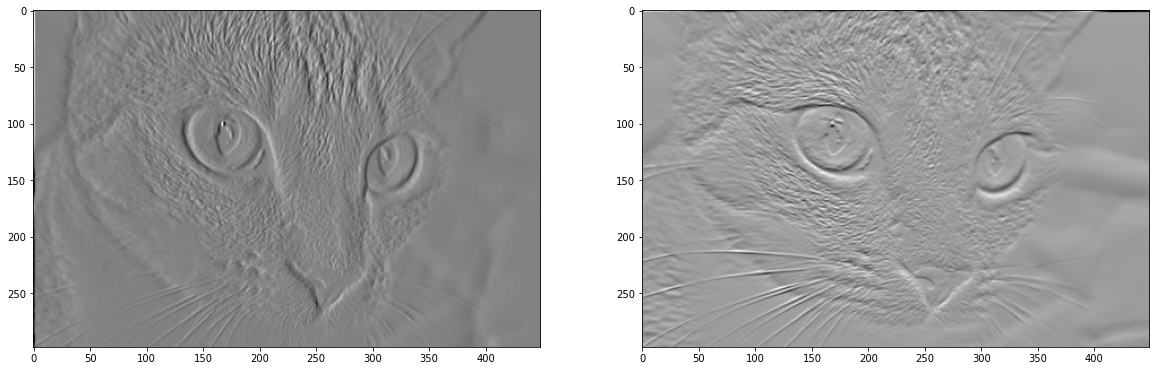

In [43]:
features = conv(img, l1_filters)
%timeit conv(img,l1_filters)

print('Convolutional feature maps shape:', features.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(features[:,:,0], cmap='gray')
ax2.imshow(features[:,:,1], cmap='gray')
plt.show()

In [34]:
# Pooling layer with particular size and stride

def pooling(feature_map, size=2, stride=2):
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride+1),
                         np.uint16((feature_map.shape[1]-size+1)/stride+1),
                         feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0,feature_map.shape[0]-size+1, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r+size,  c:c+size, map_num]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

# ReLU activation function

def relu(feature_map):
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0,feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    return relu_out

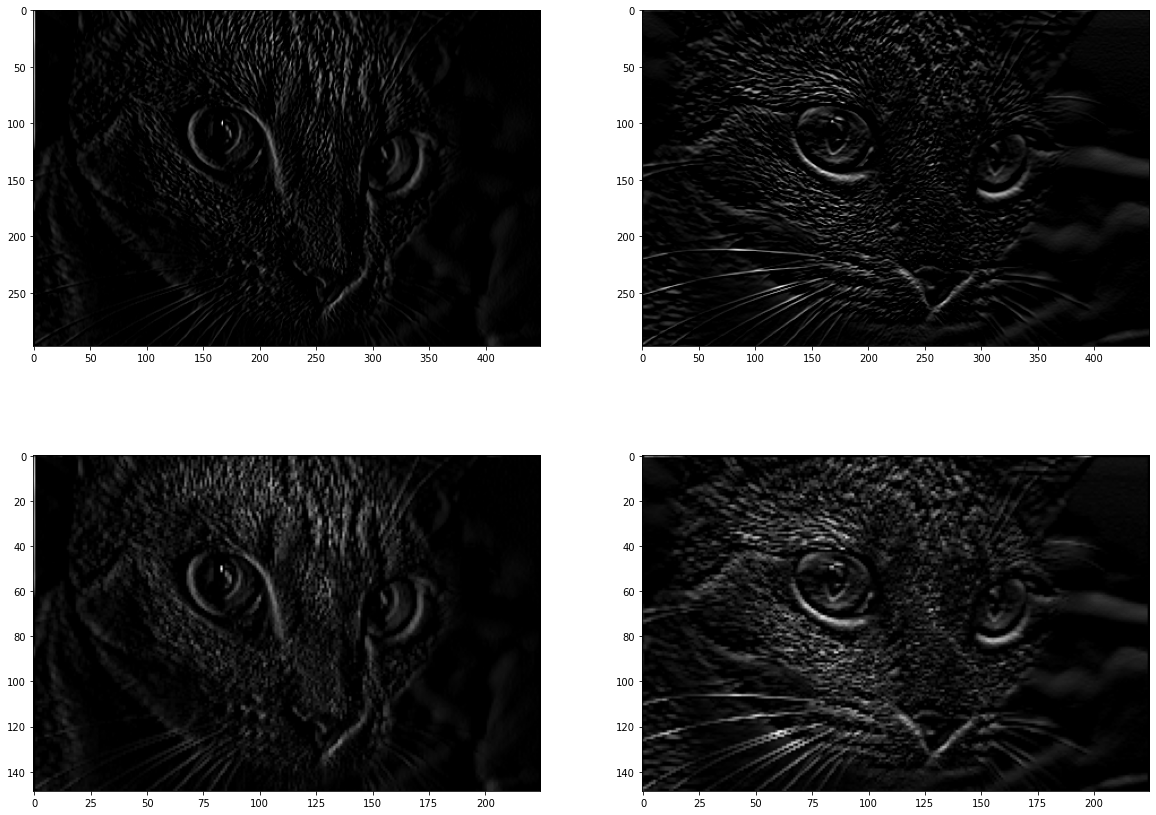

In [35]:
relued_features = relu(features)
pooled_features = pooling(relued_features)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
ax1.imshow(relued_features[:,:,0], cmap='gray')
ax2.imshow(relued_features[:,:,1], cmap='gray')
ax3.imshow(pooled_features[:,:,0], cmap='gray')
ax4.imshow(pooled_features[:,:,1], cmap='gray')
plt.show()


In [36]:
# First conv layer
import sys

np.set_printoptions(threshold=sys.maxsize)

print("conv layer 1...")
l1_feature_maps = conv(img, l1_filters)
l1_feature_maps_relu = relu(l1_feature_maps)
l1_feature_maps_relu_pool = pooling(l1_feature_maps_relu, 2, 2)

# Second conv layer

print("conv layer 2...")
l2_filters = np.random.rand(3, 5, 5, l1_feature_maps_relu_pool.shape[-1])
l2_feature_maps = conv(l1_feature_maps_relu_pool, l2_filters)
l2_feature_maps_relu = relu(l2_feature_maps)
l2_feature_maps_relu_pool = pooling(l2_feature_maps_relu, 2, 2)
#print(l2_feature_maps)

# Third conv layer

print("conv layer 3...")
l3_filters = np.random.rand(1, 7, 7, l2_feature_maps_relu_pool.shape[-1])
l3_feature_maps = conv(l2_feature_maps_relu_pool, l3_filters)
l3_feature_maps_relu = relu(l3_feature_maps)
l3_feature_maps_relu_pool = pooling(l3_feature_maps_relu, 2, 2)


conv layer 1...
conv layer 2...
conv layer 3...


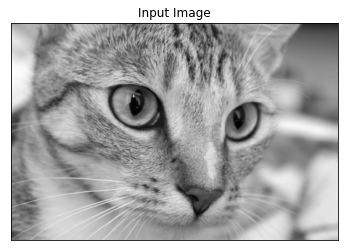

In [37]:
# Show results

fig0, ax0 = plt.subplots(nrows=1, ncols=1)
ax0.imshow(img).set_cmap("gray")
ax0.set_title("Input Image")
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
plt.show()


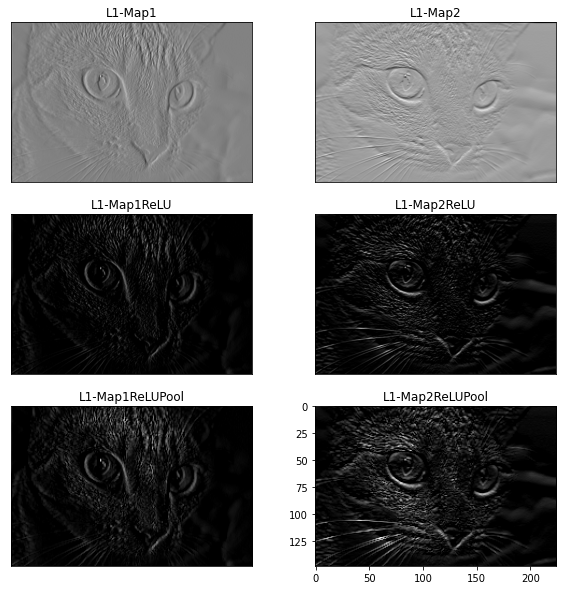

In [38]:
# Layer 1
fig1, ax1 = plt.subplots(nrows=3, ncols=2)
fig1.set_figheight(10)
fig1.set_figwidth(10)
ax1[0, 0].imshow(l1_feature_maps[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_maps[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")

plt.show()


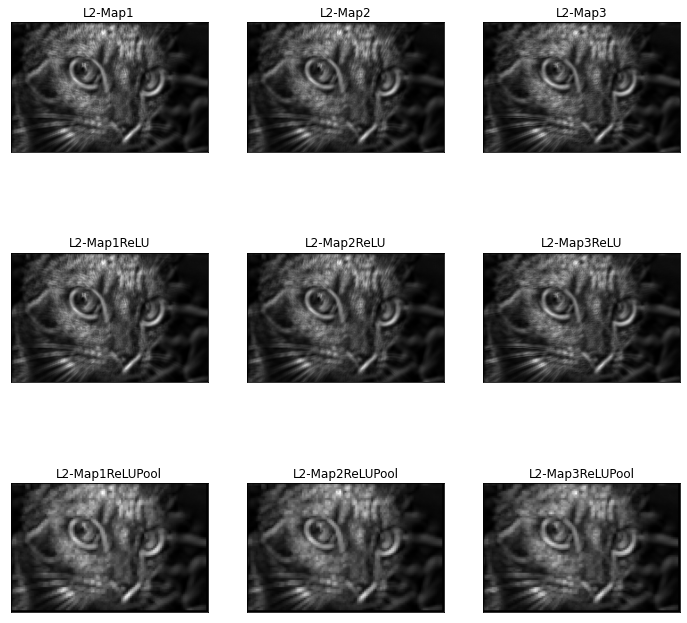

In [39]:
# Layer 2
fig2, ax2 = plt.subplots(nrows=3, ncols=3)
fig2.set_figheight(12)
fig2.set_figwidth(12)
ax2[0, 0].imshow(l2_feature_maps[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_maps[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_maps[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_maps_relu[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_maps_relu[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_maps_relu_pool[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_maps_relu_pool[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")
plt.show()

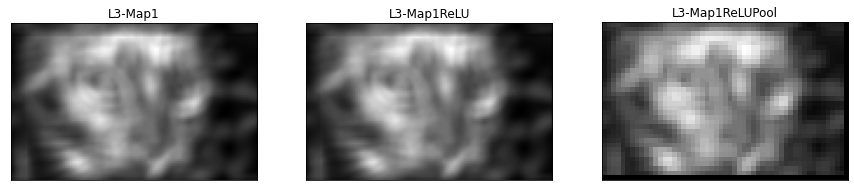

In [41]:
# Layer 3

fig3, ax3 = plt.subplots(nrows=1, ncols=3)
fig3.set_figheight(15)
fig3.set_figwidth(15)
ax3[0].imshow(l3_feature_maps[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_maps_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_maps_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool")
plt.show()

By using the numpy fft2 functions, the time it takes to perform conv() went from "1.84 s ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)" to "49.5 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)" which is about 40x faster. In order to make the convolution the same as the one before, the kernel was flipped on both its axes. 

From this exercise I gained some intuition on what happens in a convolutional layer.